In [87]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras import layers
import numpy as np
from keras.callbacks import EarlyStopping

In [88]:
path = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\Model Training"

(384, 576)

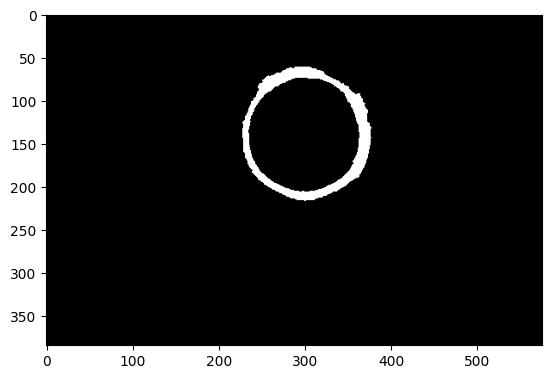

In [89]:
file = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\Model Training/01- train\Ring Mask\img\IMG_00000_flipped.jpg"
img = cv2.imread(file, 0)
plt.imshow(img, cmap='gray')
img.shape[:]

In [90]:
seed = 909
inputDataGen = ImageDataGenerator(rescale=1/255)
outputDataGen = ImageDataGenerator(rescale=1/255)

inGen = inputDataGen.flow_from_directory(path + '\\01- train\\Input', batch_size=32, class_mode=None, seed=seed, color_mode='grayscale')
outGen = inputDataGen.flow_from_directory(path + '\\01- train\\Ring Mask', batch_size=32, class_mode=None, seed=seed, color_mode='grayscale')

train_generator = zip(inGen, outGen)

Found 3082 images belonging to 1 classes.
Found 3082 images belonging to 1 classes.


In [91]:
inGen = inputDataGen.flow_from_directory(path + '\\02- test\\Input', batch_size=32, class_mode=None, seed=seed, color_mode='grayscale')
outGen = inputDataGen.flow_from_directory(path + '\\02- test\\Ring Mask', batch_size=32, class_mode=None, seed=seed, color_mode="grayscale")

test_generator = zip(inGen, outGen)

Found 749 images belonging to 1 classes.


Found 749 images belonging to 1 classes.


In [92]:
def double_conv_block(x, n_filters):

    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

    return x

In [93]:
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.5)(p)

    return f, p

In [94]:
def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate 
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.5)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x

In [95]:
def build_unet_model():

    # inputs
    inputs = layers.Input(shape=img.shape)
    inputs = layers.Input(shape=(img.shape[0], img.shape[1], 1))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = layers.Conv2D(1, 1, padding="same", activation = "softmax")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [96]:
unet_model = build_unet_model()

In [97]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 384, 576, 1)]        0         []                            
                                                                                                  
 conv2d_96 (Conv2D)          (None, 384, 576, 64)         640       ['input_13[0][0]']            
                                                                                                  
 conv2d_97 (Conv2D)          (None, 384, 576, 64)         36928     ['conv2d_96[0][0]']           
                                                                                                  
 max_pooling2d_20 (MaxPooli  (None, 192, 288, 64)         0         ['conv2d_97[0][0]']           
 ng2D)                                                                                        

In [98]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
                   loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                   #loss = 'mse',
                   metrics=["accuracy"])

es = EarlyStopping(monitor='val_loss', mode='min', patience=3, verbose=1, restore_best_weights=True)

In [99]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [100]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
NUM_EPOCHS = 205

TRAIN_LENGTH = 213
#STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
STEPS_PER_EPOCH = 13

VAL_SUBSPLITS = 5
TEST_LENTH = 27
#VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS
VALIDATION_STEPS = 5

model_history = unet_model.fit(train_generator,
                               epochs=NUM_EPOCHS,
                               steps_per_epoch=STEPS_PER_EPOCH,
                               validation_steps=VALIDATION_STEPS,
                               validation_data=test_generator,
                               #callbacks=[es]
                               )

Epoch 1/205
13/13 [==============================] - 443s 34s/step - loss: 0.6457 - accuracy: 0.0168 - val_loss: 0.6946 - val_accuracy: 0.0169
Epoch 2/205
13/13 [==============================] - 424s 33s/step - loss: 0.6266 - accuracy: 0.0169 - val_loss: 0.6908 - val_accuracy: 0.0164
Epoch 3/205
13/13 [==============================] - 432s 34s/step - loss: 0.6041 - accuracy: 0.0172 - val_loss: 0.6847 - val_accuracy: 0.0160
Epoch 4/205
13/13 [==============================] - 428s 33s/step - loss: 0.5736 - accuracy: 0.0167 - val_loss: 0.6765 - val_accuracy: 0.0174
Epoch 5/205
13/13 [==============================] - 425s 33s/step - loss: 0.5376 - accuracy: 0.0169 - val_loss: 0.6666 - val_accuracy: 0.0165
Epoch 6/205
13/13 [==============================] - 407s 31s/step - loss: 0.5034 - accuracy: 0.0168 - val_loss: 0.6536 - val_accuracy: 0.0166
Epoch 7/205
13/13 [==============================] - 404s 31s/step - loss: 0.4656 - accuracy: 0.0168 - val_loss: 0.6331 - val_accuracy: 0.0165

UnknownError: Graph execution error:

FileNotFoundError: [Errno 2] No such file or directory: 'W:\\Advanced Engineering\\Vortex Ballistics\\Gel Images\\Model Training\\01- train\\Input\\img\\IMG_00183_flipped.jpg'
Traceback (most recent call last):

  File "C:\Users\naresh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\ops\script_ops.py", line 268, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "C:\Users\naresh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\naresh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\naresh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\data_adapter.py", line 917, in wrapped_generator
    for data in generator_fn():

  File "C:\Users\naresh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\preprocessing\image.py", line 156, in __next__
    return self.next(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\naresh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\preprocessing\image.py", line 168, in next
    return self._get_batches_of_transformed_samples(index_array)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\naresh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\preprocessing\image.py", line 370, in _get_batches_of_transformed_samples
    img = image_utils.load_img(
          ^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\naresh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\utils\image_utils.py", line 422, in load_img
    with open(path, "rb") as f:
         ^^^^^^^^^^^^^^^^

FileNotFoundError: [Errno 2] No such file or directory: 'W:\\Advanced Engineering\\Vortex Ballistics\\Gel Images\\Model Training\\01- train\\Input\\img\\IMG_00183_flipped.jpg'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_27883]

In [101]:
testFile = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\Model Training\\test\Inputs\img\IMG_0467.JPG"
testImg = image.load_img(testFile, color_mode='grayscale')
testImg = np.expand_dims(testImg, axis=0)
testImg = testImg/255
testImg = testImg
imOut = unet_model.predict(testImg)

1/1 [==============================] - 1s 911ms/step


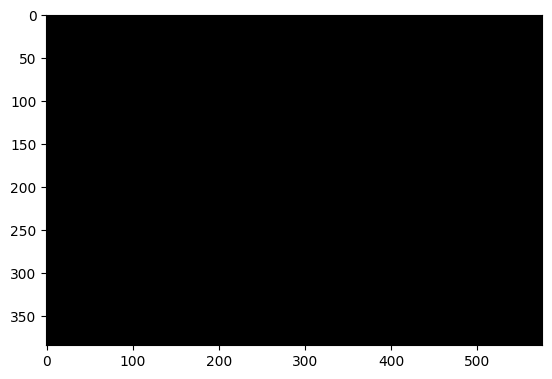

In [102]:
plt.imshow(imOut.reshape(testImg.shape[1:]), cmap = 'gray')